# `2.1 Selection`

1. Feature filtering
1. Univariate analysis

## 2.0 Libraries and constants

In [1]:
# Libraries
import pandas as pd

## 2.1 Feature filtering
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
# Constants
FORMATTED_TABLE_PATH = 'data/processed-data/1-formatted-table.csv'
DTYPES_PATH = 'data/metadata/columns.csv'
POSSIBLY_NULL_CLASSES_PATH = 'data/metadata/possibly-null-classes.csv'

# Load
FORMATTED_TABLE = pd.read_csv(FORMATTED_TABLE_PATH)
DTYPES = pd.read_csv(DTYPES_PATH, index_col=0).dtype
POSSIBLY_NULL_CLASSES = pd.read_csv(POSSIBLY_NULL_CLASSES_PATH)

In [6]:
# Data frame
german_credit_data = FORMATTED_TABLE.copy()

for column in german_credit_data.columns:
    german_credit_data[column] = german_credit_data[column].astype(DTYPES[column])

# for (column, _description) in german_credit_data.columns:
#     if column == 'A8':
#         continue

#     german_credit_data[column] = german_credit_data[column].astype(DTYPES[column])

# ## 3 Finally convert the ordinal column
# from pandas.api.types import CategoricalDtype

# ### 3.1. Define the order of your categories
# installment_categories = [1, 2, 3, 4]

# ### 3.2 Create the custom ordinal data type
# ordinal_dtype = CategoricalDtype(categories=installment_categories, ordered=True)

# ### 3.2 Apply the new data type to the column
# ordinal_column = ('A8', 'Installment rate in percentage of disposable income')
# german_credit_data[ordinal_column] = german_credit_data[ordinal_column].astype(ordinal_dtype)

## 2.1 Feature filtering

> MARKOV, Anton; SELEZNYOVA, Zinaida; LAPSHIN, Victor. **`Credit scoring methods: Latest trends and points to consider.`** The Journal of Finance and Data Science, v. 8, p. 180-201, 2022.

> DOI: 10.1016/j.jfds.2022.07.002. Available at: https://doi.org/10.1016/j.jfds.2022.07.002. Access on: 6 ago. 2025.

**Drop** feature which have more than:
- 30% of their values missing.
- 99% of their values concentrated in a single category or value.

### Before filtering
There are some classes that actually represent null values.

In [7]:
# Nullify classes that are actually encoded nulls

## For each class_label in POSSIBLY_NULL_CLASSES_PATH,
## nullify the values in its respective german_credit_data[column],
## where column is the column_label in POSSIBLY_NULL_CLASSES.

for class_label in POSSIBLY_NULL_CLASSES.class_label:
    '''
    class_label: str
    '''
    
    # 1 Get the column multiindex key for this class_label
    
    ## rows contain: column_label, column_description, class_label, class_description
    row = POSSIBLY_NULL_CLASSES.loc[
        POSSIBLY_NULL_CLASSES.class_label == class_label
    ].squeeze()
    
    ## Use only column_label and column_description to form the multiindex key
    column_key = (row.column_label, row.column_description)
    
    # 2 Map the possibly null class to np.nan
    nullifier_map = {class_label: pd.NA}

    # 3 Replace according to the map
    german_credit_data[column_key] = german_credit_data[column_key].replace(nullifier_map)


KeyError: ('A1', 'Status of existing checking account')

In [ ]:
# Test if the result mantains statistical properties

# For each class_label in POSSIBLY_NULL_CLASSES.class_label,
# check if the number of nulls in german_credit_data[column_key] is equal to the
# number of rows in POSSIBLY_NULL_CLASSES where class_label is the same.

for class_label in POSSIBLY_NULL_CLASSES.class_label:
    '''
    class_label: str
    '''
    
    # 1 Get the column multiindex key for this class_label
    
    ## rows contain: column_label, column_description, class_label, class_description
    row = POSSIBLY_NULL_CLASSES.loc[
        POSSIBLY_NULL_CLASSES.class_label == class_label
    ].squeeze()

    ## Use only column_label and column_description to form the multiindex key
    column_key = (row.column_label, row.column_description)
    
    # 2 Get the number of nulls in german_credit_data[column_key]
    num_nulls = german_credit_data[column_key].isna().sum()
    
    # 3 Get the number of rows in FORMATTED_TABLE where the value is the class_label itself
    num_rows = FORMATTED_TABLE.loc[
        FORMATTED_TABLE[column_key] == class_label
    ].shape[0]
    
    # 4 Assert that the number of nulls is equal to the number of rows
    assert num_nulls == num_rows, (
        f'Number of nulls in {column_key} ({num_nulls}) does not match the number of rows in POSSIBLY_NULL_CLASSES ({num_rows}) for class_label {class_label}.'
    )


### a) 30% of their values missing.
Columns missing more than 30% of their values:
Column | Class | Representativeness
--- | --- | --- 
A1, Status of existing checking account | A14: No checking account | 39%
A10, Other debtors / guarantors | A101: None | 91%
A14, Other installment plans | A143: None | 81%

In [ ]:
# Get missing values count per column
missing_counts = german_credit_data.isnull().sum()

/tmp/ipykernel_4718/3568009180.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  count = german_credit_data.shape[0] - missing_counts[i]


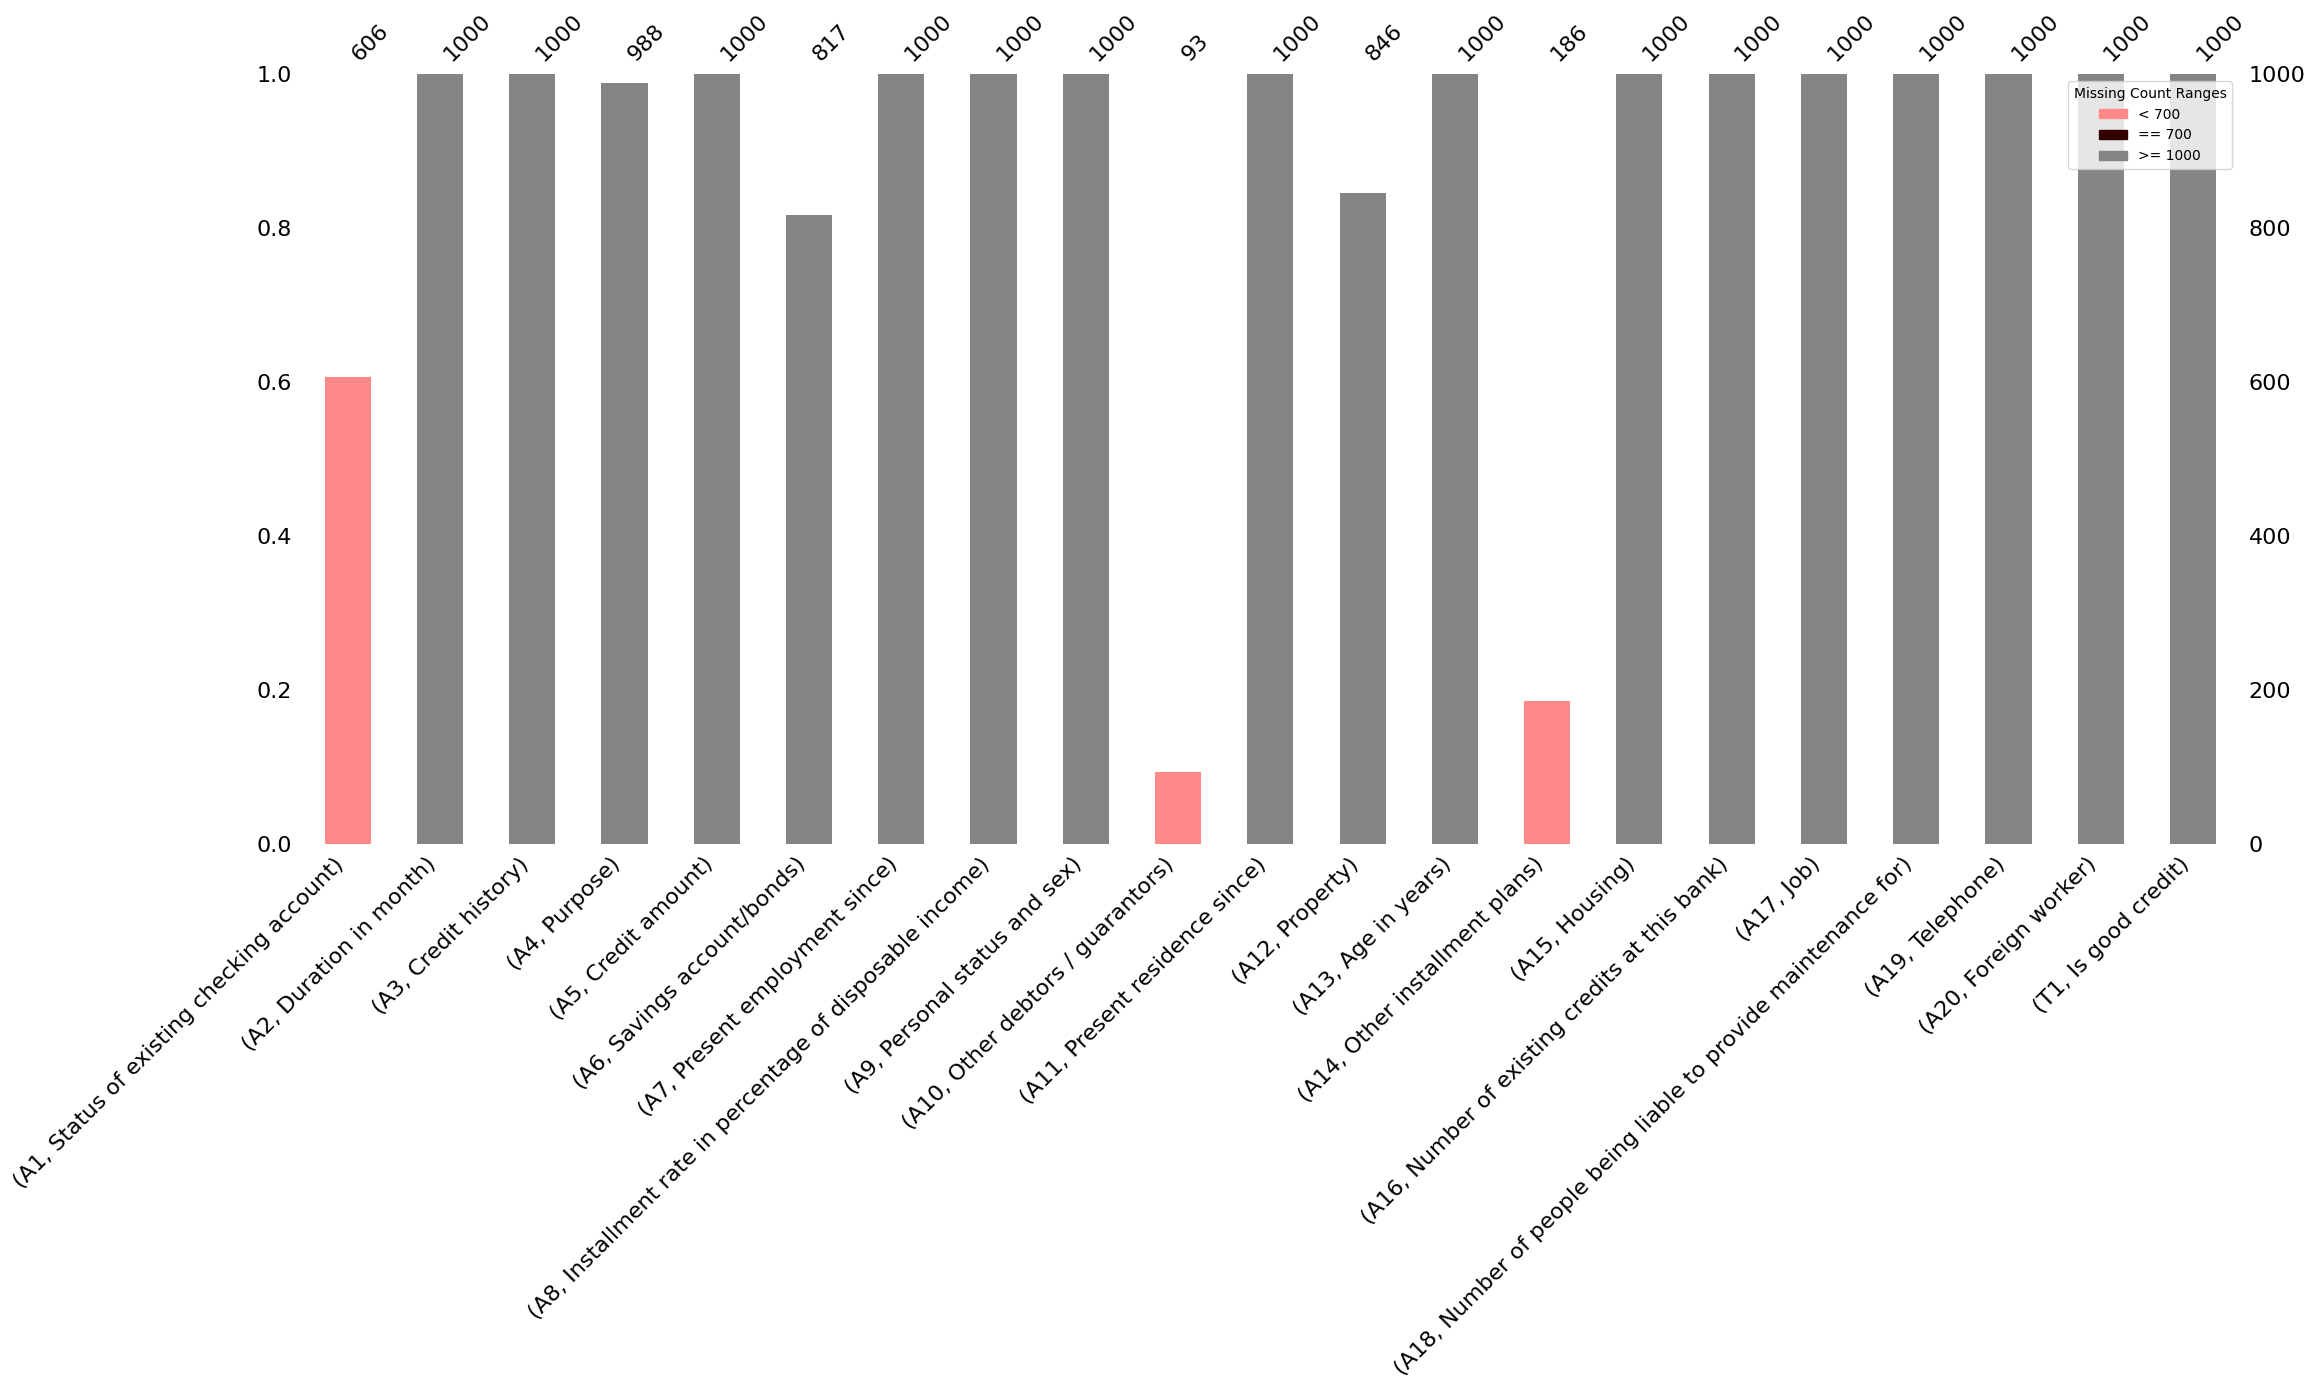

In [ ]:
# Missingno bar plot
ax = msno.bar(german_credit_data, color='grey')

# Tint bars with different red accents based on count
for i, p in enumerate(ax.patches):
    count = german_credit_data.shape[0] - missing_counts[i]
    if count <= 700:
        p.set_facecolor("#ff8989")
    elif count == 700:
        p.set_facecolor("#330000")
    else:
        p.set_facecolor("#848484FF")
        
# add legend
plt.legend(
    handles=[
        plt.Rectangle((0, 0), 1, 1, color="#7e4242", label="< 700"),
        plt.Rectangle((0, 0), 1, 1, color="#330000", label="== 700"),
        plt.Rectangle((0, 0), 1, 1, color="#C7C7C7FF", label=">= 1000")
    ],
    loc='upper right',
    title='Missing Count Ranges'
)

<Axes: >

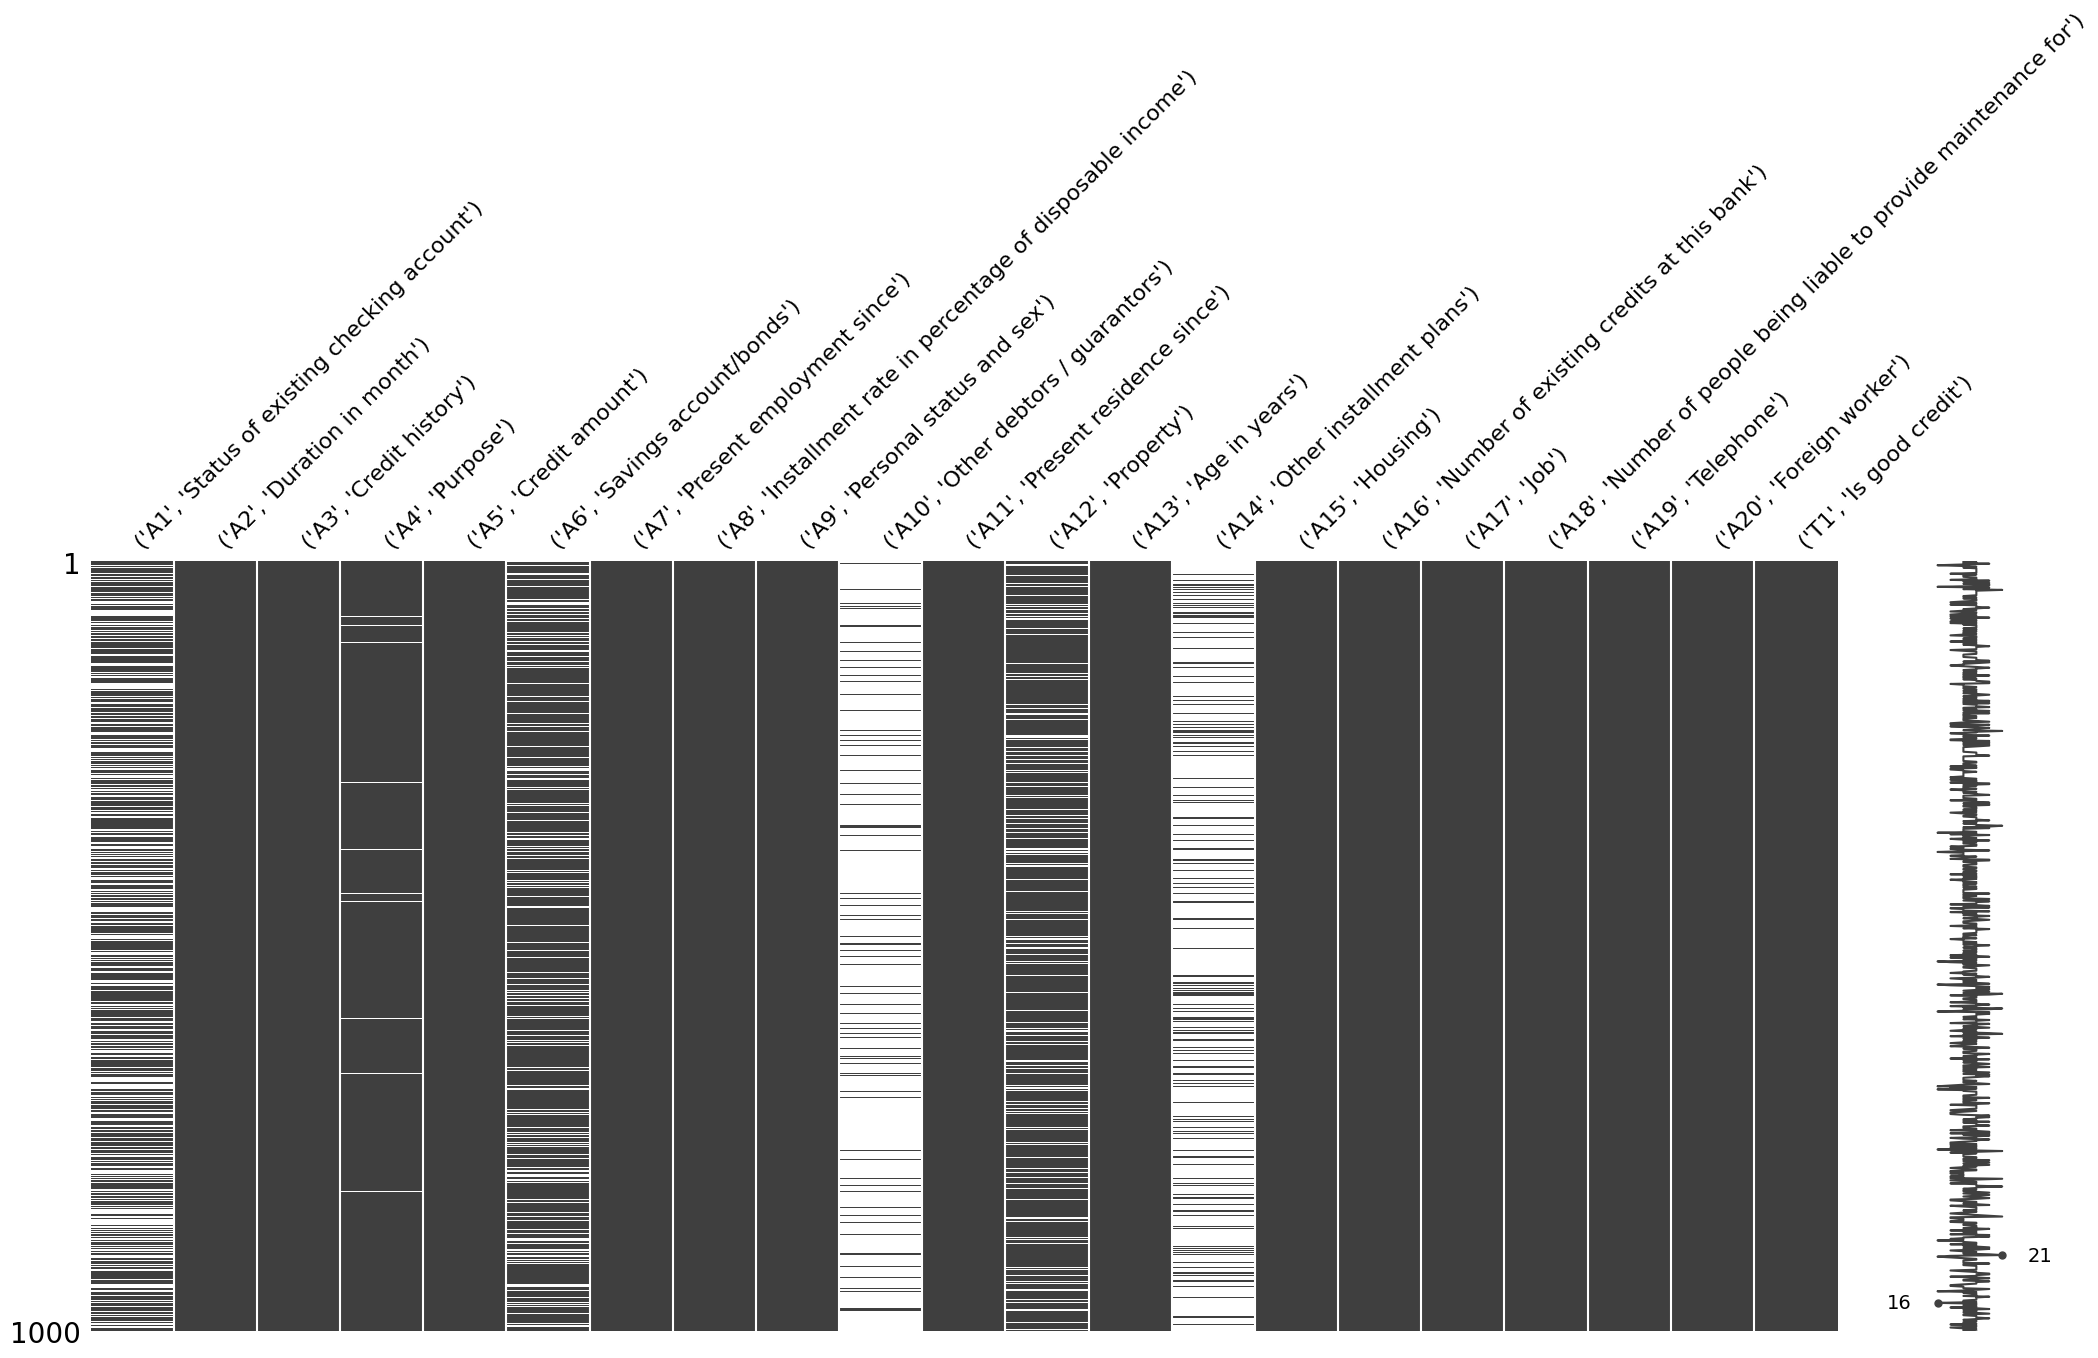

In [ ]:
# Missingno matrix plot
msno.matrix(german_credit_data)

In [ ]:
# Drop A1, A10, and A14 columns

columns_to_drop = [
    ('A1', 'Status of existing checking account'),
    ('A10', 'Other debtors / guarantors'),
    ('A14', 'Other installment plans')
]

german_credit_data = german_credit_data.drop(
    columns=[
        (column, description) for (column, description) in columns_to_drop
    ]
)

In [ ]:
# Assert that only the three columns were dropped
original_columns = set(FORMATTED_TABLE.columns)
remaining_colums = set(german_credit_data.columns)

dropped_columns = original_columns - remaining_colums

assert len(dropped_columns) == 3, (
    f'Expected 3 columns after dropping, but got {len(dropped_columns)}.'
    f' Remaining columns: {dropped_columns}'
)

assert dropped_columns.issubset(original_columns), (
    f'Dropped columns {dropped_columns} are not a subset of original columns {original_columns}.'
)

assert not dropped_columns.issubset(remaining_colums), (
    f'Dropped columns {dropped_columns} are still present in remaining columns {remaining_colums}.'
)

assert all(column not in remaining_colums for column in columns_to_drop), (
    f'Columns {columns_to_drop} were not dropped from the DataFrame.'
)

### b) 99% of their values concentrated in a single category or value.
There are no categorical columns with a single value summing up more than 99% of the values.

/tmp/ipykernel_4718/3142487540.py:6: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(german_credit_data[col]) or german_credit_data[col].dtype == "object"


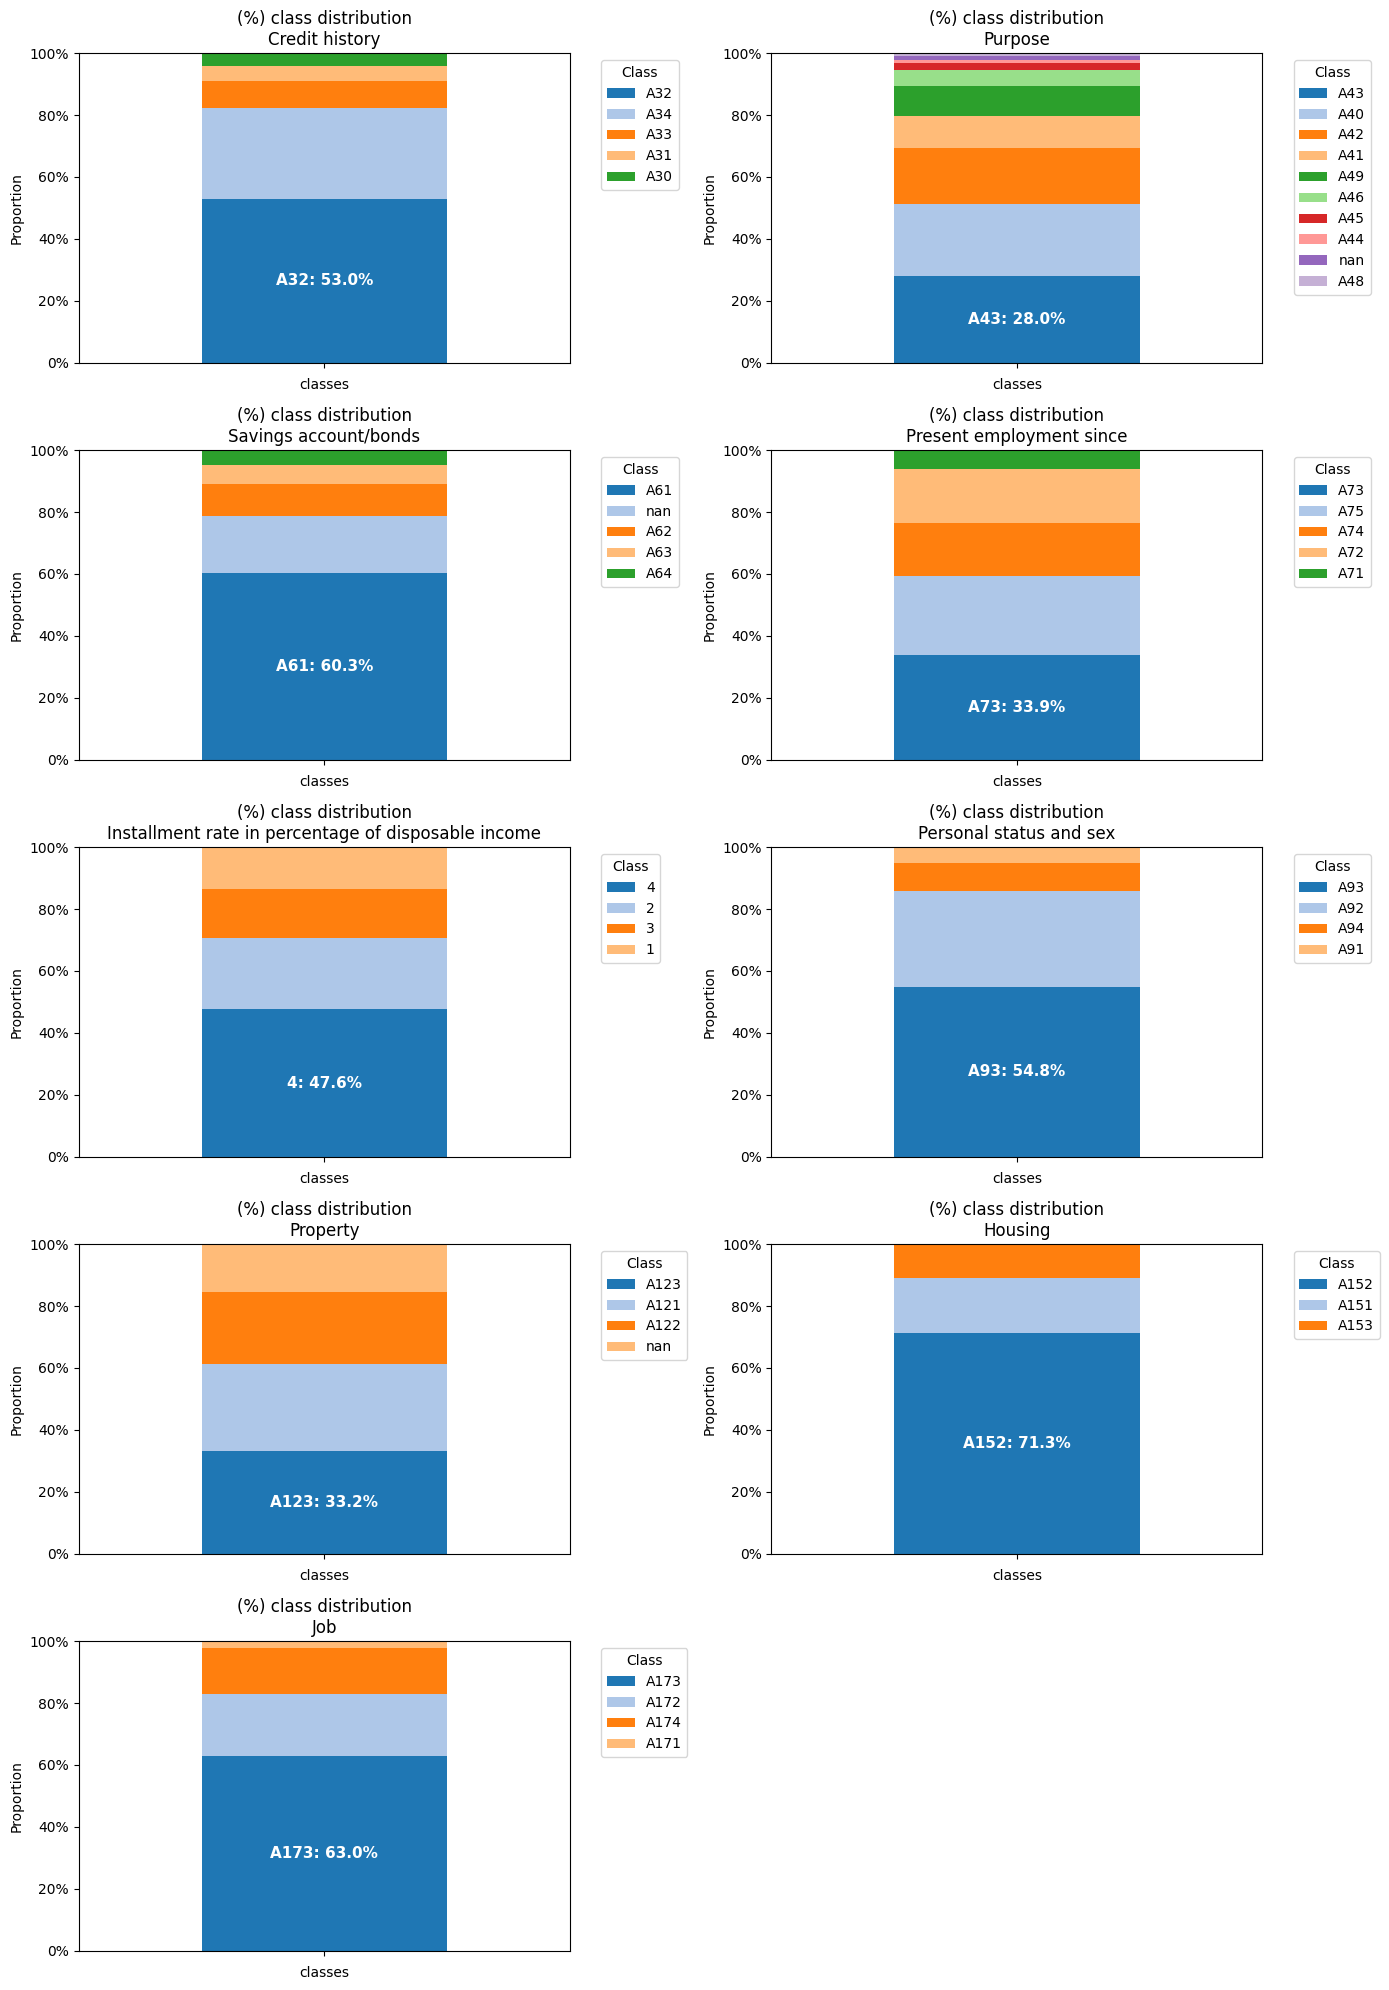

In [ ]:
# 100% stacked bar charts for all categorical columns in a single image
# Shows only the percentage of the majority class on each subplot

categorical_columns = [
    col for col in german_credit_data.columns
    if pd.api.types.is_categorical_dtype(german_credit_data[col]) or german_credit_data[col].dtype == "object"
]

n_cols = 2
n_rows = int(np.ceil(len(categorical_columns) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
axes = axes.flatten()

for idx, col in enumerate(categorical_columns):
    proportions = german_credit_data[col].value_counts(dropna=False, normalize=True)
    df_plot = proportions.to_frame().T
    df_plot.plot(
        kind="bar",
        stacked=True,
        ax=axes[idx],
        color=plt.cm.tab20.colors
    )

    major_class = proportions.idxmax()
    major_pct = proportions.max() * 100
    
    axes[idx].text(
        0, major_pct / 100 / 2,  # x=0 (unique barre), y=milieu de la barre majoritaire
        f"{major_class}: {major_pct:.1f}%",
        ha="center", va="center", color="white", fontsize=11, fontweight="bold"
    )
    axes[idx].set_title(f"(%) class distribution\n{col[1]}")
    axes[idx].set_ylabel("Proportion")
    axes[idx].set_ylim(0, 1)
    axes[idx].yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1))
    axes[idx].set_xlabel("classes")
    axes[idx].set_xticklabels([])  # Remove x-tick labels
    axes[idx].legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()


## 2.2 Univariate analysis
Univariate Analysis: The second step is to conduct an univariate analysis to assess the predictive power of individual variables. The paper mentions using statistical tests like:

Kolmogorov-Smirnov for continuous variables.

Chi-squared (χ2) for categorical variables.



In [ ]:
TARGET_COL = ('T1', 'Is good credit')

### a) Kolmogorov-Smirnov

In [ ]:
# Import
from scipy.stats import ks_2samp

In [ ]:
continuous_col = ('A5', 'Credit amount')

# Split data by target
good_credit_group  = german_credit_data[german_credit_data[TARGET_COL] == True][continuous_col].dropna()
bad_credit_group   = german_credit_data[german_credit_data[TARGET_COL] == False][continuous_col].dropna()

# Perform KS test
ks_stat, ks_pvalue = ks_2samp(good_credit_group, bad_credit_group)

print(f"KS statistic: {ks_stat:.4f}, p-value: {ks_pvalue:.4g}")

KS statistic: 0.1571, p-value: 5.484e-05


### b) Chi-squared

In [ ]:
# Import
from scipy.stats import chi2_contingency

In [ ]:
categorical_cols

[('A3', 'Credit history'),
 ('A4', 'Purpose'),
 ('A6', 'Savings account/bonds'),
 ('A7', 'Present employment since'),
 ('A8', 'Installment rate in percentage of disposable income'),
 ('A9', 'Personal status and sex'),
 ('A12', 'Property'),
 ('A15', 'Housing'),
 ('A17', 'Job')]

In [ ]:
# Identify categorical columns (excluding dropped ones)
categorical_cols = [
    col for col in german_credit_data.columns
    if DTYPES[col[0]] in ['category', 'ordinal']
]

chi2_results = []

for col in categorical_cols:
    # Build contingency table
    contingency = pd.crosstab(german_credit_data[col], german_credit_data[TARGET_COL])
    if contingency.shape[0] < 2 or contingency.shape[1] < 2:
        continue  # Skip columns with only one category or one target value

    chi2, p, dof, expected = chi2_contingency(contingency)
    chi2_results.append({
        'column': col,
        'chi2_stat': chi2,
        'p_value': p,
        'dof': dof
    })

In [ ]:
# Display results with formatted chi2_stat and p_value
df = pd.DataFrame(chi2_results)
chi2_df = pd.DataFrame(chi2_results)
chi2_df.columns = ['column', 'chi2_stat', 'p_value', 'dof']
chi2_df['column_label'] = chi2_df['column'].apply(lambda x: x[0])
chi2_df['column_description'] = chi2_df['column'].apply(lambda x: x[1])
chi2_df = chi2_df.drop(columns=['column'])

# Format only chi2_stat and p_value to scientific notation
chi2_df['chi2_stat'] = chi2_df['chi2_stat'].map(lambda x: f"{x:.2e}")
chi2_df['p_value'] = chi2_df['p_value'].map(lambda x: f"{x:.2e}")

# Reorder columns for readability
chi2_df = chi2_df[['column_label', 'column_description', 'chi2_stat', 'p_value', 'dof']]
chi2_df.sort_values('p_value', inplace=True)
chi2_df.reset_index(drop=True, inplace=True)

chi2_df

,column_label,column_description,chi2_stat,p_value,dof
0,A7,Present employment since,1.84e+01,1.05e-03,4
1,A15,Housing,1.82e+01,1.12e-04,2
2,A3,Credit history,6.17e+01,1.28e-12,4
3,A8,Installment rate in percentage of disposable i...,5.48e+00,1.40e-01,3
4,A12,Property,8.32e+00,1.56e-02,2
5,A9,Personal status and sex,9.61e+00,2.22e-02,3
6,A6,Savings account/bonds,1.85e+01,3.50e-04,3
7,A17,Job,1.89e+00,5.97e-01,3
8,A4,Purpose,3.27e+01,7.10e-05,8
